<a href="https://colab.research.google.com/github/adamwkraft/Ice-T-SNE/blob/master/Ice_T_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ice-T SNE

Visualize embedded text from Ice-T's songs and acting lines from SVU.

__Ackowledgements / Credit:__
Thanks to the following sources:
* https://github.com/johnwmillr/LyricsGenius and genius.com
* https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
* http://www.cruelhaven.org/svu/transcripts/index.html
* https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

In [0]:
# Imports

import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from urllib import request
from html.parser import HTMLParser

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets


import lyricsgenius

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding
from keras.models import Model
from keras.initializers import Constant




In [0]:
# Download song lyrics
genius = lyricsgenius.Genius("my_client_access_token_here")
artist = genius.search_artist("Ice-T", max_songs=100, sort="title")

Searching for songs by Ice-T...

Song 1: "409"
Song 2: "6 ‘N the Mornin’"
Song 3: "99 Problems"
Song 4: "Addicted to Danger"
Song 5: "Ain’t a Damn Thing Changed"
Song 6: "Always Wanted to be a Ho"
Song 7: "Art Of Rap Freestyle 2"
Song 8: "Big Gun"
Song 9: "Bitches 2"
Song 10: "Black ‘N’ Decker"
Song 11: "Body Count"
Song 12: "Body Rock"
Song 13: "Check Your Game"
Song 14: "Check Your Heart"
Song 15: "Chrome plated 357"
Song 16: "CJ Mac Interlude"
Song 17: "Code of the streets"
Song 18: "Cold as Ever"
Song 19: "Cold Wind Madness (AKA The Coldest Rap, Pt. 2)"
Song 20: "Colors"
Song 21: "Common Sense"
Song 22: "Cramp Your Style"
Song 23: "Dear Homie"
Song 24: "Depths of Hell"
Song 25: "Disorder"
Song 26: "Dog ‘N’ The Wax"
Song 27: "Don’t Hate the Playa"
Song 28: "Drama"
Song 29: "Ed"
Song 30: "Escape from the Killing Fields"
Song 31: "Evil E: What About Sex?"
Song 32: "Exodus"
Song 33: "Eye of the Storm"
Song 34: "First Impression"
Song 35: "Fly By"
Song 36: "Forced to Do Dirt"
Song 37: "

In [0]:
# Save song lyrics
song_lyrics = []
num_songs =  len(artist.songs)
for song in artist.songs:
  song_fname = '{}.txt'.format(song.title).replace('/', '_')
  with open(song_fname, 'w') as f:
    f.write(song.lyrics)

In [0]:
# Collect SVU Lines
url_name_tups = [
    ('http://www.cruelhaven.org/svu/transcripts/loss.html', 'Fin'),
    ('http://www.cruelhaven.org/svu/transcripts/serendipity.html', 'Det. Odafin Tutuola'),
    ('http://www.cruelhaven.org/svu/transcripts/sick.html', 'Det. Odafin Tutuola'),
    ('http://www.cruelhaven.org/svu/transcripts/poison.html', 'Det. Odafin Tutuola')
]


class SVUScriptParser(HTMLParser):
  
  def __init__(self, name):
    super(SVUScriptParser, self).__init__()
    self._name = name
    self._got_ice_t = False
    self._cur_line = ''
    self.lines = []
  
  def handle_data(self, data):
    if not self._got_ice_t and data == self._name:
      self._got_ice_t = True
    elif self._got_ice_t:
      self._cur_line += data
      if re.match('^.*\\\\n\\\\n', data):
        self.lines.append(re.sub('\\\\n', '', self._cur_line))
        self._cur_line = ''
        self._got_ice_t = False

  

def get_lines(url, name):
  # Get lines for an SVU URL and name of Ice-T's character name
  parser = SVUScriptParser(name)
  with request.urlopen(url) as f:
    script_html = str(f.read())
  parser.feed(script_html)
  return parser.lines

svu_lines = [get_lines(url, name) for url, name in url_name_tups]
all_svu_lines = sum(svu_lines, [])

In [0]:
# Prep Data
songs = [s.lyrics for s in artist.songs]
songs_words = [len(s.lyrics) for s in artist.songs]
num_songs = len(songs)
num_script_lines = len(all_svu_lines)
script_line_words = [len(l) for l in all_svu_lines]

texts = songs + all_svu_lines
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6109 unique tokens.


In [0]:
# Download embedding file
!curl -v -o glove.6B.zip http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [0]:
# Unzip embedding file
!unzip glove.6B.zip

In [0]:
# Create embedding matrix
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_index[word] = coefs

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
MAX_SEQUENCE_LENGTH = max([len(s.lyrics) for s in artist.songs])
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [0]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(MAX_NUM_WORDS,
                            EMBEDDING_DIM,
#                             embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
model = Model(sequence_input, embedded_sequences)


In [0]:
# Embed texts
sequences = tokenizer.texts_to_sequences(texts)
data_input = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
embedded_texts = model.predict(data_input)
print(embedded_texts.shape)

(195, 8274, 100)


In [0]:
mask = np.ones_like(embedded_texts)
for i, num_words in enumerate(songs_words + script_line_words):
  mask[i, :-num_words, :] = 0
X = embedded_texts * mask
X = np.mean(X, axis=1)
print(X.shape)

(195, 100)


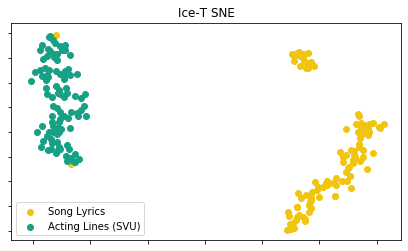

In [0]:
tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=10)
Y = tsne.fit_transform(X)

# Plot
_, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.set_title('Ice-T SNE')
ax.scatter(Y[:num_songs, 0], Y[:num_songs, 1], c="#F1C40F")
ax.scatter(Y[num_songs:, 0], Y[num_songs:, 1], c="#16A085")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(['Song Lyrics', 'Acting Lines (SVU)'])